# 特征预处理
created by Vulcan626 on 2023/11/29

对Adult数据集进行特征预处理，包括：
- 数据清洗
- 特征编码
- 数据转换

In [21]:
# 导入包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [22]:
# 导入数据

# 指定列名
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                'marital_status', 'occupation', 'relationship', 'race', 'sex',
                'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
                'income']

# 读取数据
data = pd.read_csv('adult/adult.data', header=None, names=column_names, na_values=' ?')


## 1. 查看数据
查看数据特征，包括数据前5行、数据特征、数据类型等，以便对后续数据进行处理。

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0          2174             0              40   United-States   <=50

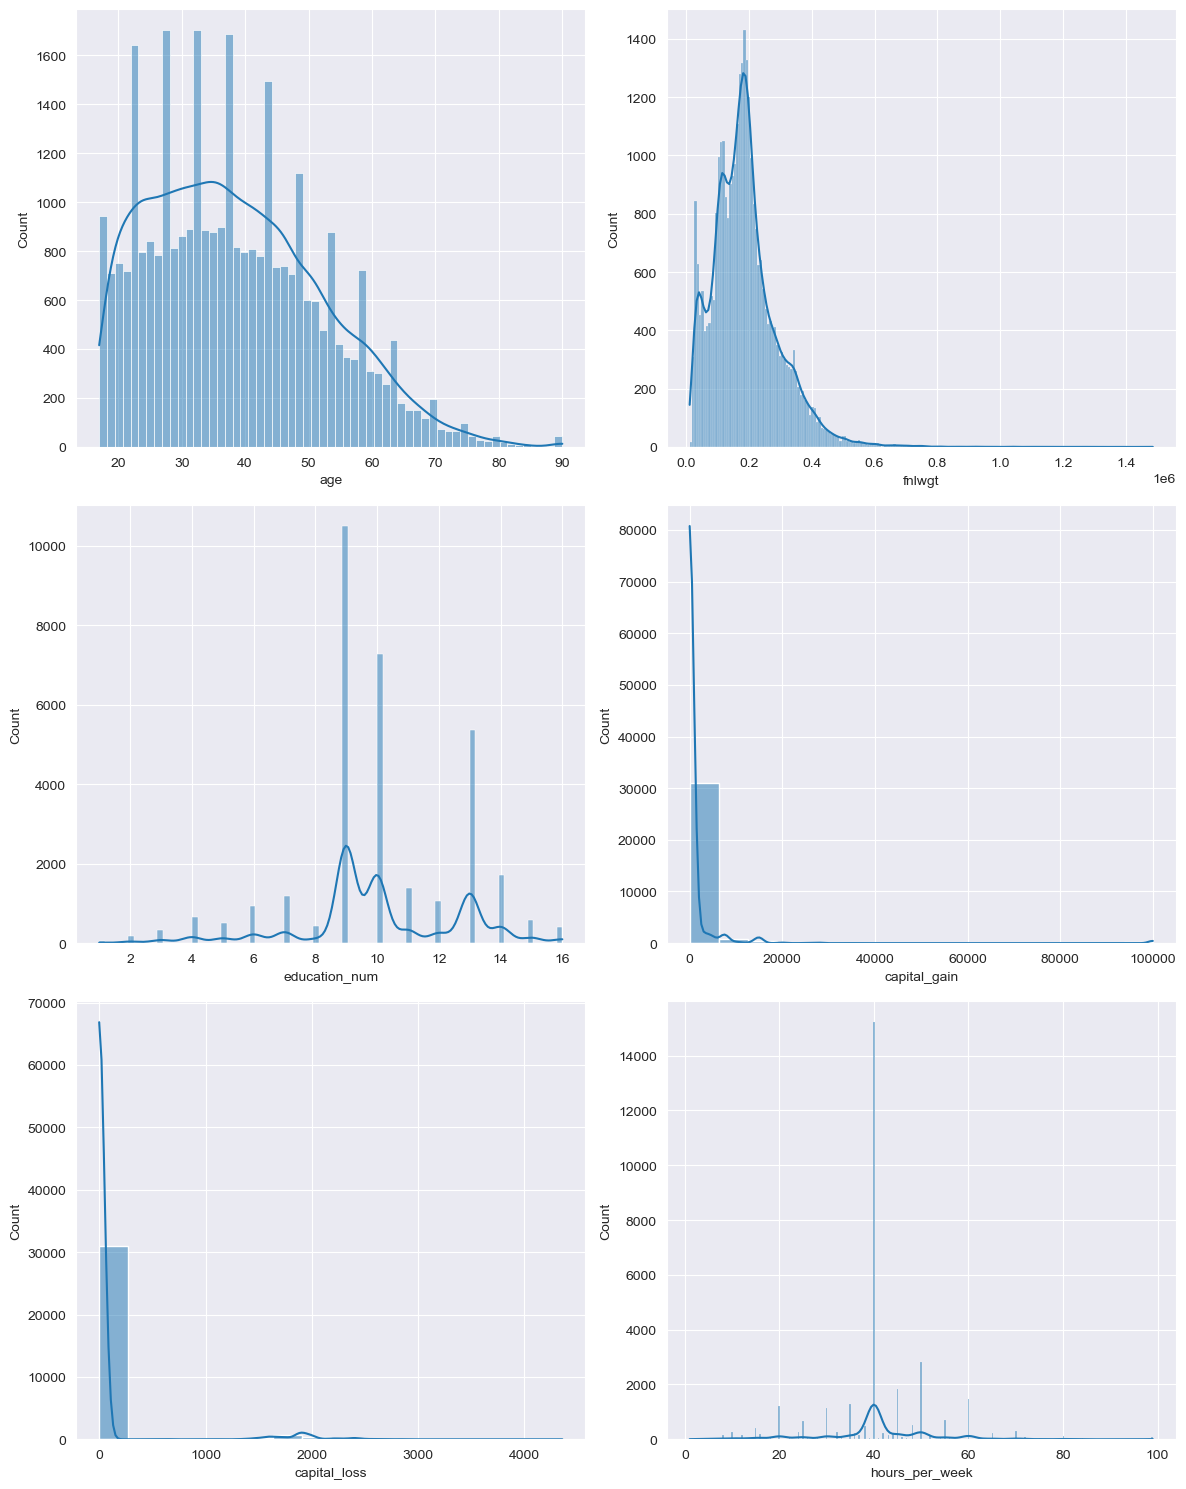

In [23]:
# 查看数据前5行
print(data.head())

# 查看数据特征
print(data.shape)

# 查看数据类型
print(data.info())

# 查看数据统计信息
print(data.describe())

# 绘图查看数据分布
# 创建一个 3x2 的图表布局
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
# 绘制每个特征的分布图
sns.histplot(data['age'], ax=axes[0, 0], kde=True)
sns.histplot(data['fnlwgt'], ax=axes[0, 1], kde=True)
sns.histplot(data['education_num'], ax=axes[1, 0], kde=True)
sns.histplot(data['capital_gain'], ax=axes[1, 1], kde=True)
sns.histplot(data['capital_loss'], ax=axes[2, 0], kde=True)
sns.histplot(data['hours_per_week'], ax=axes[2, 1], kde=True)
# 调整布局以避免子图之间的重叠
plt.tight_layout()
plt.show()

## 2. 数据清洗
- 处理缺失值
- 处理离群点


In [24]:
# 处理缺失值

# 检查每列的缺失值数量
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

workclass         1836
occupation        1843
native_country     583
dtype: int64

In [25]:
# 填充缺失值
# 对于 'workclass' 和 'occupation'，使用众数填充缺失值
# 对于 'native_country'，使用占位符 'Unknown' 填充缺失值

workclass_mode = data['workclass'].mode()[0]  # 获取 'workclass' 的众数
occupation_mode = data['occupation'].mode()[0]  # 获取 'occupation' 的众数

data['workclass'].fillna(workclass_mode, inplace=True)  # 用 'workclass' 的众数填充其缺失值
data['occupation'].fillna(occupation_mode, inplace=True)  # 用 'occupation' 的众数填充其缺失值
data['native_country'].fillna('Unknown', inplace=True)  # 用 'Unknown' 填充 'native_country' 的缺失值

# 检查是否还有缺失值
updated_missing_values = data.isnull().sum()
updated_missing_values[updated_missing_values > 0]  # 显示仍有缺失值的列（如果有的话）

Series([], dtype: int64)

In [26]:
# 处理离群点

# 创建一个空字典，用于存储离群点信息
outliers_info = {}

# 创建一个处理后的数据副本
data_cleaned = data.copy()

# 对每个数值特征进行离群点检测和处理
for column in ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']:
    # 计算Q1和Q3
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # 确定离群点
    outliers = (data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR))
    outliers_count = outliers.sum()

    # 存储处理前的离群点统计信息
    outliers_info[column] = {
        'outliers_count': outliers_count,
        'percentage': (outliers_count / len(data)) * 100
    }

    # 将离群点替换为中位数
    median_value = data[column].median()
    data_cleaned.loc[outliers, column] = median_value

    # 检查处理后的数据
    new_outliers = (data_cleaned[column] < (Q1 - 1.5 * IQR)) | (data_cleaned[column] > (Q3 + 1.5 * IQR))
    new_outliers_count = new_outliers.sum()

    # 更新字典以体现处理后的情况
    outliers_info[column].update({
        'new_outliers_count': new_outliers_count,
        'outliers_removed': outliers_count - new_outliers_count
    })

# 输出离群点处理的统计信息
outliers_info_df = pd.DataFrame(outliers_info).T
outliers_info_df



,outliers_count,percentage,new_outliers_count,outliers_removed
age,143.0,0.439176,0.0,143.0
fnlwgt,992.0,3.046589,0.0,992.0
education_num,1198.0,3.679248,0.0,1198.0
capital_gain,2712.0,8.328983,0.0,2712.0
capital_loss,1519.0,4.665090,0.0,1519.0
hours_per_week,9008.0,27.664998,0.0,9008.0


## 3. 特征编码
使用OneHotEncoder对数据集进行特征编码，将数据集中的类别特征转换为数值特征。

In [27]:
# 选择需要进行独热编码的列
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation',
                       'relationship', 'race', 'sex', 'native_country']

# 创建独热编码器
encoder = OneHotEncoder(sparse_output=False)

# 对分类数据进行独热编码
encoded_data = encoder.fit_transform(data_cleaned[categorical_columns])

# 将编码后的数据转换为DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# 合并原始数据集与编码后的数据
adult_data_encoded = pd.concat([data_cleaned.drop(categorical_columns, axis=1), encoded_df], axis=1)

# 显示转换后的数据集
print(adult_data_encoded.head())

   age  fnlwgt  education_num  capital_gain  capital_loss  hours_per_week  \
0   39   77516             13             0             0              40   
1   50   83311             13             0             0              40   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   28  338409             13             0             0              40   

   income  workclass_ Federal-gov  workclass_ Local-gov  \
0   <=50K                     0.0                   0.0   
1   <=50K                     0.0                   0.0   
2   <=50K                     0.0                   0.0   
3   <=50K                     0.0                   0.0   
4   <=50K                     0.0                   0.0   

   workclass_ Never-worked  ...  native_country_ Puerto-Rico  \
0                      0.0  ...                          0.0   
1                      0.0  ...                       

## 4. 数据转换
使用StandardScaler对数据集进行标准化，将数据集中的数值特征缩放到相同的尺度。

In [28]:
# 特征缩放

# 选择数值型列
numeric_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain',
                   'capital_loss', 'hours_per_week']

# 创建标准化器
scaler = StandardScaler()

# 对数值型数据进行标准化
adult_data_encoded[numeric_columns] = scaler.fit_transform(adult_data_encoded[numeric_columns])

# 显示标准化后的数据
print(adult_data_encoded[numeric_columns].head())


        age    fnlwgt  education_num  capital_gain  capital_loss  \
0  0.046949 -1.186558       1.214388           0.0           0.0   
1  0.873974 -1.119195       1.214388           0.0           0.0   
2 -0.028235  0.419093      -0.602660           0.0           0.0   
3  1.099527  0.640825      -1.511183           0.0           0.0   
4 -0.780076  1.846115       1.214388           0.0           0.0   

   hours_per_week  
0       -0.324809  
1       -0.324809  
2       -0.324809  
3       -0.324809  
4       -0.324809  


## 5. 保存数据
- 重新查看数据，确保数据处理完成。
- 将数据保存到本地。

(32561, 107)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Columns: 107 entries, age to native_country_Unknown
dtypes: float64(106), object(1)
memory usage: 26.6+ MB
None
                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  3.256100e+04  3.256100e+04   3.256100e+04       32561.0       32561.0   
mean   1.105415e-17  9.978062e-17   2.901221e-16           0.0           0.0   
std    1.000015e+00  1.000015e+00   1.000015e+00           0.0           0.0   
min   -1.607101e+00 -1.944816e+00  -2.419707e+00           0.0           0.0   
25%   -7.800756e-01 -7.179744e-01  -6.026597e-01           0.0           0.0   
50%   -1.034188e-01 -1.437315e-02  -1.483979e-01           0.0           0.0   
75%    6.484221e-01  5.417286e-01   7.601257e-01           0.0           0.0   
max    2.979129e+00  2.746270e+00   2.577173e+00           0.0           0.0   

       hours_per_week  workclass_ Federal-gov  workclass_ Local-gov  \
count  

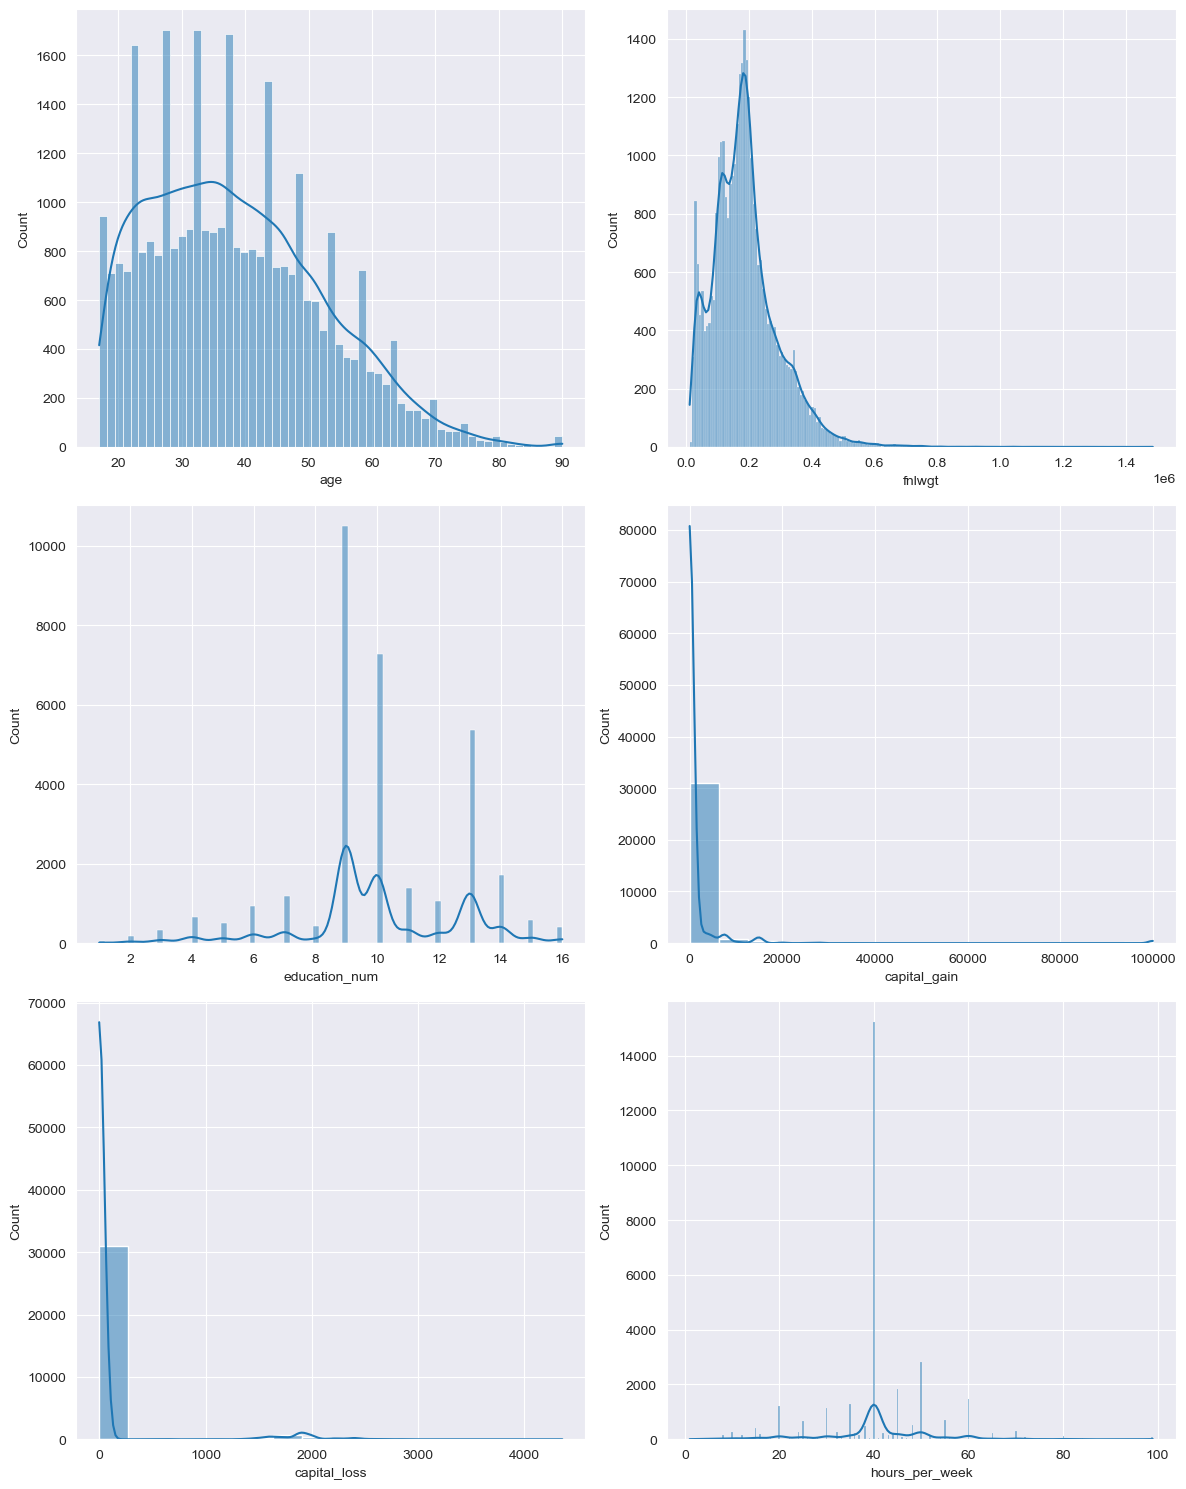

In [29]:
# 重新查看数据
print(adult_data_encoded.shape)
print(adult_data_encoded.info())
print(adult_data_encoded.describe())

# 绘图查看数据分布
# 创建一个 3x2 的图表布局
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
# 绘制每个特征的分布图
sns.histplot(data['age'], ax=axes[0, 0], kde=True)
sns.histplot(data['fnlwgt'], ax=axes[0, 1], kde=True)
sns.histplot(data['education_num'], ax=axes[1, 0], kde=True)
sns.histplot(data['capital_gain'], ax=axes[1, 1], kde=True)
sns.histplot(data['capital_loss'], ax=axes[2, 0], kde=True)
sns.histplot(data['hours_per_week'], ax=axes[2, 1], kde=True)
# 调整布局以避免子图之间的重叠
plt.tight_layout()
plt.show()

In [30]:
# 保存数据
adult_data_encoded.to_csv('adult/adult_data_encoded.csv', index=False)